In [1]:
import operator
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from data_grabbers.cases_data_grabber import CasesDataGrabber
from data_grabbers.deaths_data_grabber import DeathsDataGrabber
from models.NeuralNetModel import NeuralNetModel
from models.PolynomialRegressionModel import PolynomialRegressionModel

In [3]:
def grab_training_set(datagrabber_class, grab_data_from_server=True, offline_dataset_date=""):
    grabber = globals()[datagrabber_class]()
    dataset_date = ""

    if grab_data_from_server:
        grabber.grab_data()
    else:
        dataset_date = offline_dataset_date

        if offline_dataset_date == "":
            raise Exception("Invalid offline dataset date received. Please update the 'offline_dataset_date' configuration in the config file and try again.")
    
    filename = grabber.get_dataset_file_name(dataset_date=dataset_date)

    return np.genfromtxt("datasets/" + filename, delimiter=',').astype(np.int32)

In [4]:
def get_model(x, y, model_config):
    if model_config["model"]["type"] == "regression":
        regression_model = PolynomialRegressionModel(model_config["model_name"], model_config["model"]["polynomial_degree"])
        regression_model.train(x, y)

        return regression_model
    elif model_config["model"]["type"] == "neural_net":
        neural_net_model = NeuralNetModel(model_config["model_name"])
        neural_net_model.train(x, y, model_config["model"]["hidden_layer_sizes"], model_config["model"]["learning_rate"], model_config["model"]["max_iter"])
        
        return neural_net_model
    
    return None

In [5]:

def plot_graph(model_name, x, y, y_pred):
    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)
    
    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

In [6]:
def print_forecast(model_name, model, beginning_day=0, limit=10):
    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = model.get_predictions(next_days_x)

    print("The forecast for " + model_name + " in the following " + str(limit) + " days is:")

    for i in range(0, limit):
        print("Day " + str(i + 1) + ": " + str(next_days_pred[i]))

In [7]:

def print_stats(model_config, x, y, model):
    y_pred = model.get_predictions(x)

    print_forecast(model_config["model_name"], model, beginning_day=len(x), limit=model_config["days_to_predict"])

    if isinstance(model, PolynomialRegressionModel):
        print("The " + model_config["model_name"] + " model function is: f(X) = " + model.get_model_polynomial_str())

    plot_graph(model_config["model_name"], x, y, y_pred)
    print("")


In [8]:
def model_handler(model_config):
    training_set = grab_training_set(model_config["datagrabber_class"], model_config["grab_data_from_server"], model_config["offline_dataset_date"])
    x = training_set[:, 0].reshape(-1, 1)
    y = training_set[:, 1]
    model = get_model(x, y, model_config)

    print_stats(model_config, x, y, model)


The forecast for Cases in the following 10 days is:
Day 1: 7880886
Day 2: 7989887
Day 3: 8098887
Day 4: 8207888
Day 5: 8316828
Day 6: 8425634
Day 7: 8534440
Day 8: 8643247
Day 9: 8752053
Day 10: 8860859


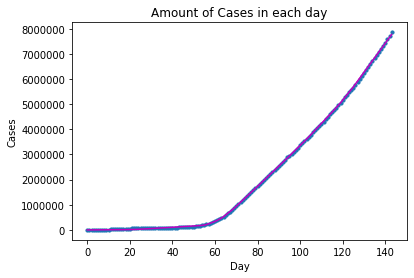


The forecast for Deaths in the following 10 days is:
Day 1: 454384
Day 2: 459616
Day 3: 464848
Day 4: 470080
Day 5: 475312
Day 6: 480544
Day 7: 485776
Day 8: 491008
Day 9: 496240
Day 10: 501472


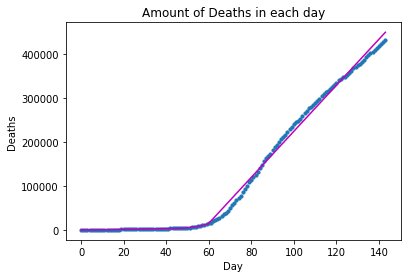

In [9]:
if __name__ == "__main__":
    config = {}

    with open("config.json", "r") as f:
        config = json.load(f)

    for model_config in config["models"]:
        if "enabled" in model_config and model_config["enabled"] == False:
            continue
        
        model_handler(model_config)